Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/10


c:\Users\Phillip Risager\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5484 - loss: 30.8405
Epoch 1: val_accuracy improved from -inf to 0.61333, saving model to model\vgg19_best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.5497 - loss: 30.5606 - val_accuracy: 0.6133 - val_loss: 2.0815
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8627 - loss: 0.5343
Epoch 2: val_accuracy improved from 0.61333 to 0.62000, saving model to model\vgg19_best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8626 - loss: 0.5342 - val_accuracy: 0.6200 - val_loss: 1.6352
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9289 - loss: 0.1880
Epoch 3: val_accuracy improved from 0.62000 to 0.65333, saving model to model\vgg19_best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.9291 - loss: 0.1875 - val_accuracy: 0.6533 - val_loss: 2.0748
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9675 - loss: 0.0949
Epoch 4: val_accuracy did not

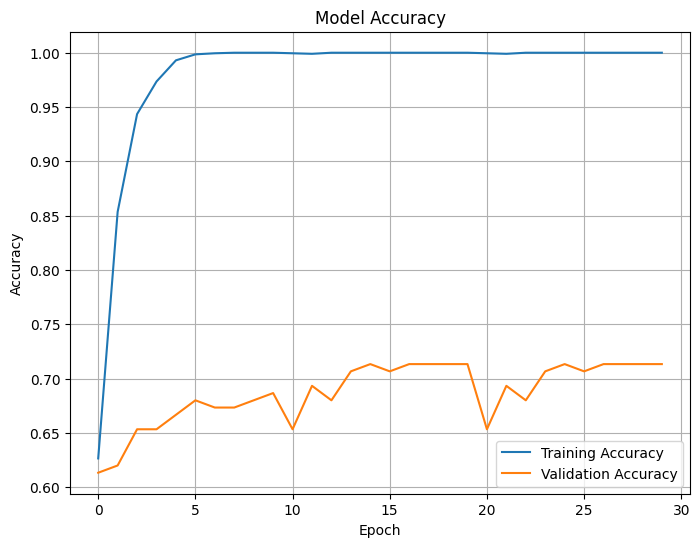

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Define paths
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
model_dir = 'model'
model_path = os.path.join(model_dir, 'vgg19_best_model.keras')
final_model_path = os.path.join(model_dir, 'vgg19_final_model.keras')

# Create model directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Image data generators for training, validation, and testing sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load VGG19 model without the top layer (include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a model checkpoint callback
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Unfreeze some layers of VGG19 and fine-tune the model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile the model for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Combine history
history.history['accuracy'].extend(history_fine_tune.history['accuracy'])
history.history['val_accuracy'].extend(history_fine_tune.history['val_accuracy'])

# Load the best saved model
best_model = load_model(model_path)

# Save the final model
model.save(final_model_path)

# Define labels
labels = {0: 'Melanoma', 1: 'Nevus', 2: 'Seborrheic Keratosis'}

def load_and_prepare_image(image_path: str, target_size: tuple = (224, 224)) -> np.ndarray:
    """
    Loads and preprocesses an image for VGG19 model prediction.

    Parameters:
    - image_path (str): Path to the image file.
    - target_size (tuple): Desired image size for the model (width, height).

    Returns:
    - np.ndarray: Preprocessed image ready for model input.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file at {image_path} does not exist.")
    
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

def predict_mole(image_path: str, model: Model) -> str:
    """
    Predicts the class of a mole image using the trained model.

    Parameters:
    - image_path (str): Path to the image file.
    - model (Model): Loaded Keras model.

    Returns:
    - str: Predicted class label with confidence percentage.
    """
    prepared_image = load_and_prepare_image(image_path)
    predictions = model.predict(prepared_image)
    predicted_class_indices = np.argmax(predictions, axis=1)
    confidence = predictions[0][predicted_class_indices[0]] * 100
    predicted_label = labels.get(predicted_class_indices[0], "Unknown")
    return f"The uploaded mole is predicted to be: {predicted_label} with a confidence of {confidence:.2f}%"

# Example usage
test_image_path = 'user_image/test.jpg'

try:
    result = predict_mole(test_image_path, best_model)
    print(result)
except Exception as e:
    print(f"Error: {e}")

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'] + history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
